## Week 05 : 웹 크롤링 II

In [16]:
import re
import pandas as pd
import numpy as np
import json
import time
from datetime import datetime, timedelta

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from collections import Counter
from itertools import chain
from operator import itemgetter

basic_header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36',
                "Accept":"text/html,application/xhtml+xml,application/xml;\q=0.9,imgwebp,*/*;q=0.8"}            

In [17]:
def url_to_soup(input_url) :
    session = requests.Session()
    req = session.get(input_url, headers=basic_header, allow_redirects=True)
    soup = BeautifulSoup(req.text, 'lxml')
    return soup

soup = url_to_soup('http://underscore.kr/')

In [18]:
for h2 in soup.find_all('h2') :
    print(h2.a['href'])

http://underscore.kr/istrollingcontagious/
http://underscore.kr/politaku/
http://underscore.kr/genderindanger/
http://underscore.kr/goodhigschoolanduniv/
http://underscore.kr/hotweatherkillspeople/
http://underscore.kr/arenoobsmoreconfident/


In [19]:
title_list = [each.a.text for each in soup.find_all('h2')]
suburl_list = [each.a['href'] for each in soup.find_all('h2')]

underscoredf = pd.DataFrame(zip(title_list, suburl_list), columns=['title', 'url'])

underscoredf['len_title'] = underscoredf['title'].str.len()
underscoredf['len_url'] = underscoredf['url'].str.len()
underscoredf['source'] = 'underscore'
underscoredf['digit_len_title'] = underscoredf['len_title'].astype(str).str.len()
underscoredf['doubled_len_title'] = underscoredf['len_title']*2

In [20]:
predatesoup = soup.find_all('span', {'class':'posted-on'})
date_list = []
for each in predatesoup :
    date_list.append(each.find_all('time')[-1]['datetime'])

In [21]:
predatesoup = soup.find_all('span', {'class':'posted-on'})
date_list = [each.find_all('time')[-1]['datetime'] for each in predatesoup]

In [22]:
underscoredf = \
pd.DataFrame(zip(title_list, suburl_list, date_list), columns=['title', 'url', 'time'])
underscoredf

,title,url,time
0,왜 자꾸 어그로를 끄는 거야!,http://underscore.kr/istrollingcontagious/,2018-09-28T19:30:42+00:00
1,페이스북으로 ‘정잘알’이 될 수 있을까?,http://underscore.kr/politaku/,2018-09-16T00:20:45+00:00
2,당신은 남자답지 않습니다,http://underscore.kr/genderindanger/,2018-09-08T23:59:15+00:00
3,좋은 고등학교를 가면 대학 입시에서 유리할까?,http://underscore.kr/goodhigschoolanduniv/,2018-08-28T20:01:48+00:00
4,"덥다, 더워! 데이터가 알려주는 더위와 자살률의 관계",http://underscore.kr/hotweatherkillspeople/,2018-08-13T20:53:25+00:00
5,진짜로 잘 모르는 사람이 더 용감할까?,http://underscore.kr/arenoobsmoreconfident/,2018-08-02T18:18:07+00:00


In [23]:
tag_list = []
for each_url in tqdm(underscoredf['url']) :
    time.sleep(1)
    cnsoup = url_to_soup(each_url)
    tag_list.append([a.text for a in cnsoup.find('span', {'class':'tags-links'}).find_all('a')])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.35s/it]


In [82]:
# 언더스코어 페이지 데이터프레임 최종 생성
underscoredf = \
pd.DataFrame(zip(title_list, suburl_list, date_list, tag_list), columns=['title', 'url', 'date', 'tag'])

underscoredf['date'] = pd.to_datetime(underscoredf['date'])
underscoredf['month_date'] = underscoredf['date'].dt.strftime('%Y%m').astype(int)
underscoredf['num_tag'] = underscoredf['tag'].str.len()
underscoredf['first_tag'] = underscoredf['tag'].str[0]
underscoredf['second_tag'] = underscoredf['tag'].str[1]

In [86]:
underscoredf.to_csv('./data/20211110_underscore_v1.csv')

In [106]:
x = pd.read_csv('./data/20211110_underscore_v1.csv', index_col=0)
x['tag'][1]

"['미디어', '심리학']"

In [111]:
underscoredf.to_pickle('./data/20211110_underscore_v1.p')

In [122]:
underscoredf = pd.read_pickle('./data/20211110_underscore_v1.p')
underscoredf['len_title'] = underscoredf['title'].str.len()
underscoredf['len_url'] = underscoredf['url'].str.len()

In [127]:
import numpy as np
import pandas as pd

In [136]:
np.round(20.7834234, 1)

20.8

In [142]:
from collections import Counter

In [143]:
Counter(underscoredf['first_tag'])

Counter({'사회학': 3, '미디어': 1, '심리학': 2})

In [146]:
underscoredf['first_tag'].value_counts(normalize=True)

사회학    0.500000
심리학    0.333333
미디어    0.166667
Name: first_tag, dtype: float64

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'

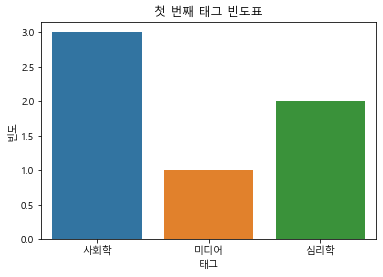

In [167]:
plt.title('첫 번째 태그 빈도표')
sns.countplot(x='first_tag', data=underscoredf)
plt.xlabel('태그')
plt.ylabel('빈도')
plt.savefig('./image/first_tag_frequency.png', dpi=300)

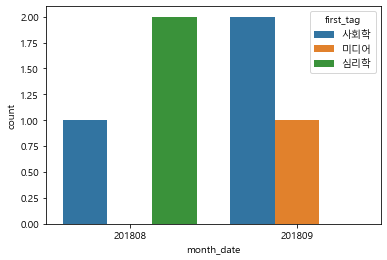

In [170]:
sns.countplot(x='month_date', hue='first_tag', data=underscoredf)

In [11]:
mainsoup = url_to_soup('https://imnews.imbc.com/pc_main.html')

mbc_title_list = []
mbc_url_list = []
mbc_writer_list = []

for li in mainsoup.find_all('li', {'class':'ellipsis'}) :
    mbc_url_list.append(li.a['href'])
    mbc_title_list.append(li.a.text)
    
for article_url in mbc_url_list :
    time.sleep(.7)
    article_soup = url_to_soup(article_url)
    mbc_writer_list.append(article_soup.find('span', {'class':'writer'}).text)  

In [12]:
pd.DataFrame(zip(mbc_title_list, mbc_url_list, mbc_writer_list))

,0,1,2
0,"정정용호·박항서호, FIFA 선정 '2019년 가장 놀라운 팀'",https://imnews.imbc.com/news/2019/sports/artic...,박주린
1,"'연봉 14억원' 김진수, 프로축구 K리그 국내 선수 '연봉킹'",https://imnews.imbc.com/news/2019/sports/artic...,박주린
2,"[EPL] '마네 결승골' 리버풀, 울버햄프턴 꺾고 19경기 무패 선두",https://imnews.imbc.com/news/2019/sports/artic...,박주린
3,"백승호·이강인, 김학범호 합류 '불발'…윤종규 발탁",https://imnews.imbc.com/news/2019/sports/artic...,박주린
4,"손흥민, 토트넘 2010년대 '최고의 골' 후보에 최다 4골 올려",https://imnews.imbc.com/news/2019/sports/artic...,박주린
5,"전국 곳곳에서 성탄 미사·예배…""자비와 은총을""",https://imnews.imbc.com/news/2019/culture/arti...,양효경
6,"5천년전 밀양 토기서 옻 확인…""국내 최고 사례""",https://imnews.imbc.com/news/2019/culture/arti...,양효경
7,문화재 해외 불법 반출 음모 처벌 강화…벌금형 삭제,https://imnews.imbc.com/news/2019/culture/arti...,양효경
8,'고바우 영감' 김성환 화백 금관문화훈장,https://imnews.imbc.com/news/2019/culture/arti...,양효경
9,"'한국의 탈춤', 내년 유네스코 인류무형문화유산 등재 도전",https://imnews.imbc.com/news/2019/culture/arti...,박소희
